# Goal: Identify and Analyze Mobile Device Usage for 6.00.2x

1) Identify Mobile clicks

2) Isolate Mobile clicks

3) Agents, Events, and Event Types (for reference to clickstream data structure, see https://edx.readthedocs.io/projects/devdata/en/stable/internal_data_formats/tracking_logs.html)

Potential research questions:
    <br> - How often are mobile devices used with the 6.00.1x course?
    <br> - How do users interact with the 6.00.1x course on mobile devices?
    <br> - What patterns of behavior can we see in the mobile clickstream data?
    <br> - Hypothesis: Users on mobile click differently than non-mobile uers.

notes 
<br> nfs = network file system
<br> work with both courses
<br> interesting user? what makes someone an interesting user? frequent clicks? let's start with that.

In [1]:
!ls /yw_data/alfad8/newmitx 
! python --version

ls: cannot access '/yw_data/alfad8/newmitx': No such file or directory
Python 3.7.4


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from no_PII_Storage_folder import *

In [3]:
%run all_utilities.ipynb
#all functions are in this notebook

In [4]:
user_data = pd.read_csv('\ALL_DATA.csv')

In [5]:
user_data = user_data.drop(['Unnamed: 0'], axis = 1)
user_data.head(5)

,time,username,event_source,agent,name
0,2016-12-07 21:42:40.253149 UTC,5d482518821e6facc112c940cab04e15,server,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,edx.course.enrollment.activated
1,2016-12-07 21:44:28.023229 UTC,d41d8cd98f00b204e9800998ecf8427e,server,python-requests/2.9.1,NaN
2,2017-03-27 07:03:52.170765 UTC,86d70a75d701a090a36c9c3e07ed4b0f,browser,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,problem_save
3,2017-03-27 23:35:27.52683 UTC,6527b22f2839a8f2fc8c243b5c6442ca,browser,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,problem_save
4,2017-03-27 17:40:21.371003 UTC,86d70a75d701a090a36c9c3e07ed4b0f,browser,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,problem_save


In [6]:
mobile_data = pd.read_csv(r'MOBILE_DATA.csv')
non_mobile_data = pd.read_csv(r'NON_MOBILE_DATA.csv')

mobile_data = mobile_data.drop(['Unnamed: 0'], axis = 1)
non_mobile_data = non_mobile_data.drop(['Unnamed: 0'], axis = 1)

In [7]:
mobile_data.head(n = 3)

,time,username,event_source,agent,name
0,2017-03-27 16:21:54.930867 UTC,1fc8371d6fb5d841af64503da54e4ec4,browser,Mozilla/5.0 (Linux; Android 7.1.1; A0001 Build...,problem_check
1,2017-03-27 12:55:42.111315 UTC,aa75ce9861e361e2201c070fee4876ae,browser,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,problem_check
2,2017-03-27 19:03:01.540341 UTC,f7c9b5ba8e176a40998faa3874f04378,browser,Mozilla/5.0 (Linux; Android 5.0.2; HTC One Bui...,problem_check


In [8]:
#counts number of unique event_sources

num_unique = user_data['event_source'].nunique(dropna = True)
unique_es = user_data['event_source'].unique()
print(num_unique)
print(unique_es)

3
['server' 'browser' 'mobile']


In [9]:
#check for mobile info in event source for comparison to user_agent info

mobile_data_es = pd.DataFrame()
        
mobile_data_es = mobile_data[mobile_data['event_source'].str.contains("mobi")] 
     
#assert len(mobile_data_es) == 0
print("\nThere are " + str(len(mobile_data_es)) + " event-sources in mobile_data that contain:  mobi")


There are 13 event-sources in mobile_data that contain:  mobi


In [10]:
#count different distinct events, then event types
#agent = mobile device/browser info, event =  includes member fields that identify specifics of each triggered event (?)
#name = event type, event_source = the source of the interaction that triggered the event

col_names = ['agent', 'name', 'event_source', 'username']
list_names = ['unique_agents', 'unique_names', 'unique_event_sources', 'unique_usernames']
num_unique = []
all_uniques = []
        
all_uniques = unique_counts(col_names, mobile_data)

# print("\n", all_uniques[2])
# print("\n", all_uniques[3])


There are 2342 unique agents.

There are 43 unique names.

There are 3 unique event_sources.

There are 1645 unique usernames.


In [11]:
len(user_data)

7817269

# Check data with NaN elements removed

NONE of the the clicks that suggest a mobile device from 'user_agent' info are also listed as mobile in 'event_source info' *not true with all data -- now 13
<br>NOTE* the plots below do NOT use dataframes with NaN elements removed, however, given the plots labels, it doesn't appear to be an issue

In [12]:
user_data_no_nan = user_data.dropna()
user_data_no_nan = user_data_no_nan.reset_index(drop=True)
print(len(user_data_no_nan))
user_data_no_nan.head(n = 2)

3329792


,time,username,event_source,agent,name
0,2016-12-07 21:42:40.253149 UTC,5d482518821e6facc112c940cab04e15,server,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,edx.course.enrollment.activated
1,2017-03-27 07:03:52.170765 UTC,86d70a75d701a090a36c9c3e07ed4b0f,browser,Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52....,problem_save


In [13]:
#Searches for mobile users and adds them to new data frame with ONLY mobile users (WITH NAN GONE)
MOBILE_INDICATOR_1 = "mobi"
MOBILE_INDICATOR_2 = "Mobi"

mobile_data_no_nan = pd.DataFrame()

mobile_data_no_nan = user_data[user_data['agent'].str.contains(MOBILE_INDICATOR_1) | user_data['agent'].str.contains(MOBILE_INDICATOR_2)] 
mobile_data_no_nan = mobile_data_no_nan.reset_index(drop=True)
        
print("\nThere are " + str(len(mobile_data_no_nan)) + " user-agents that contain: Mobi or mobi")

mobile_data_no_nan.head(3)


There are 129545 user-agents that contain: Mobi or mobi


,time,username,event_source,agent,name
0,2017-03-27 16:21:54.930867 UTC,1fc8371d6fb5d841af64503da54e4ec4,browser,Mozilla/5.0 (Linux; Android 7.1.1; A0001 Build...,problem_check
1,2017-03-27 12:55:42.111315 UTC,aa75ce9861e361e2201c070fee4876ae,browser,Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X)...,problem_check
2,2017-03-27 19:03:01.540341 UTC,f7c9b5ba8e176a40998faa3874f04378,browser,Mozilla/5.0 (Linux; Android 5.0.2; HTC One Bui...,problem_check


In [14]:
col_names = ['agent', 'name', 'event_source']
list_names = ['unique_agents', 'unique_names', 'unique_event_sources']
num_unique_no = []
all_uniques_no = []
        
all_uniques_no = unique_counts(col_names, mobile_data_no_nan)

print(all_uniques_no[2])


There are 2342 unique agents.

There are 43 unique names.

There are 3 unique event_sources.
['browser' 'server' 'mobile']


# Visualizing Data

plot to visualize modes, distributions, etc.
<br>-bar graphs of value counts for name, event (+ maybe agent, but that's messy so probably just display information)
<br>-same for non-mobile users^ (to look @ difference)
<br>-how can we look at behavior? aggregate OR groupby user
<br>-add error bars, pie charts could also visualize well

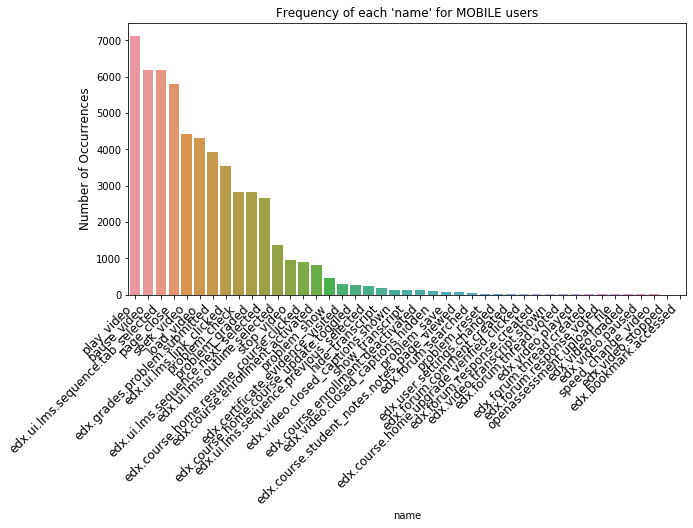

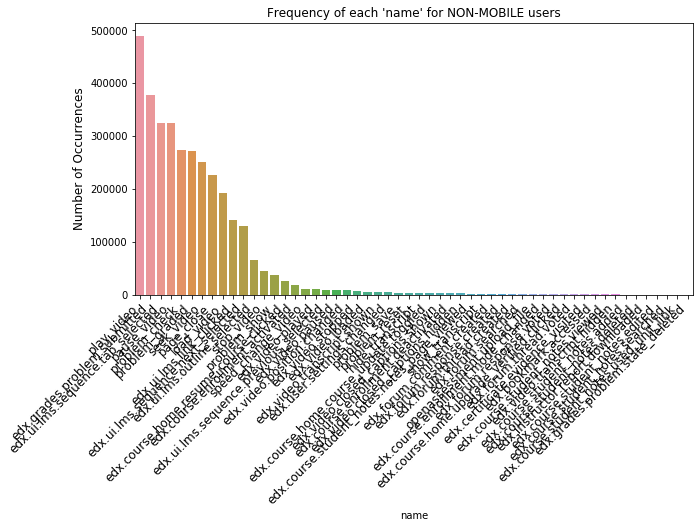

7687724


In [15]:
#function that plots frequencies of agent, event, name, and event_course 

name_count  = mobile_data['name'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(name_count.index, name_count.values, alpha=1)
plt.title("Frequency of each 'name' for MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('name', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()
non_name_count  = non_mobile_data['name'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(non_name_count.index, non_name_count.values, alpha=1)
plt.title("Frequency of each 'name' for NON-MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('name', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()
print(len(non_mobile_data))

In [16]:
#code for plotted pie charts, commented because they were minimally helpful

# name_count.plot.pie(subplots=True, figsize=(6, 6))
# plt.legend(bbox_to_anchor=(2.5,0), loc="lower right")
# non_name_count.columns = ['values']
# non_name_count.plot.pie(subplots=True, figsize=(10, 10))
# plt.legend(bbox_to_anchor=(2.5,0), loc="lower right")

pause_video is most popular for mobile and non_mobile users (graphing takes a while to figure out, go for percentages to begin to quantify difference?) NOTES:
<br>page_close more popuar for mobile users (suggests minimal time spent on mobile course?)
<br>edx.grades.problem.submitted popular for both
<br> make better graphs, graph side by side, normalize, make above graph side-by-side

okay, so because of formatting updates, a lots of the names are actually the same...like pause_video is the same as edx.video.paused...sooooo I'm gonna fix that (fixed!)

In [17]:
#fix data frames
name_count = name_count.to_frame()
name_count = name_count.reset_index()
name_count.columns = ['name', 'values']

non_name_count = non_name_count.to_frame()
non_name_count = non_name_count.reset_index()
non_name_count.columns = ['name', 'values']

len(name_count)

43

In [18]:
#create list of all values that will serve as replacements (replacements will be older, original names because the 
#newer names are present with ONLY SOME OF THE MOBILE USERS)
replace_this = []
replace_with = []

replace_this = ['edx.video.transcript.hidden', 'edx.video.loaded', 'edx.video.paused', 'edx.video.played',
               'edx.video.position.changed', 'edx.video.transcript.shown', 'edx.video.stopped',
               'edx.video.language_menu.hidden', 'edx.video.language_menu.shown']
replace_with = ['hide_transcript', 'load_video', 'pause_video', 'play_video', 'seek_video', 'show_transcript',
               'stop_video', 'video_hide_cc_menu', 'video_show_cc_menu']

In [19]:
mobile =  []
non_mobile =  []
name_count_cpy = name_count
non_name_count_cpy = non_name_count

name_count_cpy = replace_copies(name_count, replace_this, replace_with)
non_name_count_cpy = replace_copies(non_name_count, replace_this, replace_with)
#non_name_count_cpy == non_name_count

x_scaled = normalize_data(name_count)
y_scaled = normalize_data(non_name_count)

# Run the normalizer on the data

name_count_normalized = apply_normalizer(x_scaled, 'mobile', mobile)
non_name_count_normalized = apply_normalizer(y_scaled, 'non-mobile', non_mobile)
non_name_count_normalized.head(3)
    
result_1 = pd.concat([name_count, name_count_normalized], axis=1, sort=False)
result_2 = pd.concat([non_name_count, non_name_count_normalized], axis=1, sort=False)
result = pd.concat([result_1, result_2], axis = 0, sort = False)
result = result.reset_index(drop=True)

#remove very small occurences
for count in range(len(result)):
    if result['normalized'][count] < 0.05:
        result = result.drop(labels = [count], axis = 0)

result = result.reset_index(drop=True).sort_values(by = 'normalized', ascending = False)
result = result.reset_index(drop=True)

result.head(3)

,name,values,normalized,device
0,play_video,7130,1.000000,mobile
1,play_video,489527,1.000000,non-mobile
2,pause_video,6182,0.867022,mobile


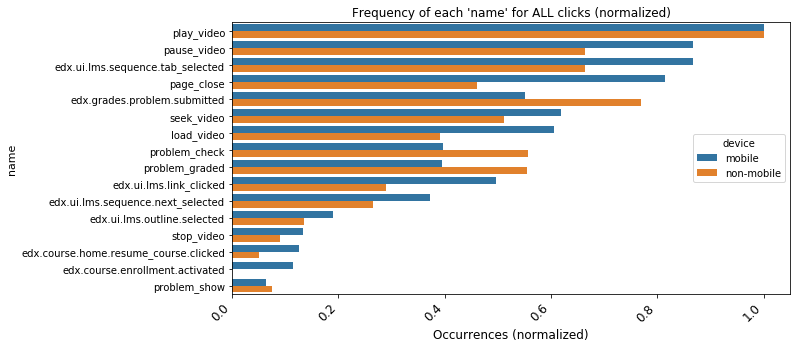

In [20]:
#make a horizontal bar plot with side by side data
plt.figure(figsize=(10,5))

sns.barplot(x = result['normalized'], y =  result['name'], hue = "device", data = result)
plt.title("Frequency of each 'name' for ALL clicks (normalized)")
plt.xlabel('Occurrences (normalized)', fontsize=12)
plt.ylabel('name', fontsize=11)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

-all users' interactions are typically video-based
<br>-pause_video and tab_selected the same???

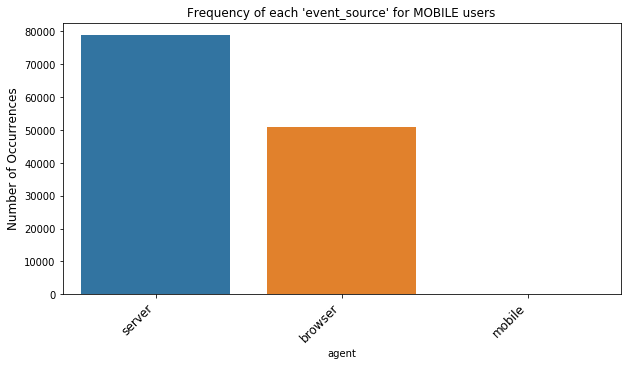

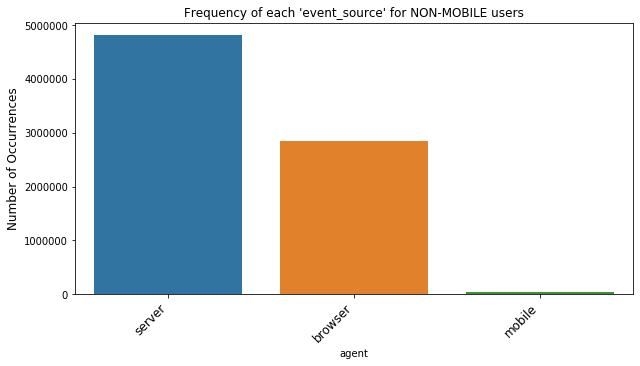

In [21]:
#event source plots...minimally helpful

name_count  = mobile_data['event_source'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(name_count.index, name_count.values, alpha=1)
plt.title("Frequency of each 'event_source' for MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('agent', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

non_name_count  = non_mobile_data['event_source'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(non_name_count.index, non_name_count.values, alpha=1)
plt.title("Frequency of each 'event_source' for NON-MOBILE users")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('agent', fontsize=10)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

# Find Interesting Users

take top 5 usernames, normalize and plot their frequencies to look @ individual behavior

In [22]:
#Find users with most total clicks. Alternatively, look at users with highest number of distinct clicks (wait...that doesn't make sense...nevermind)
# PLOTS BELOW USE DATAFRAMES WITH NaN ELEMENTS REMOVED

NUM_TOP = 6
#no nan because lots of nans in names????
data_copy  = mobile_data.dropna()
data_copy = data_copy.reset_index(drop=True)

top_users = get_top_users(data_copy, NUM_TOP)

top_users.head(NUM_TOP)

,index,username,no. clicks
0,0,9589599fce0cecbe02eb2b02457b1ef6,2838
1,1,3693313ce79182c3009e6414b3ade459,2471
2,2,d39491d5e973c40e3b1e5957cce823ee,1893
3,3,d41d8cd98f00b204e9800998ecf8427e,1381
4,4,bed7f1f1761c5368859d1421fcb4e013,1239
5,5,eb97b8fc1faff95a146c939d4316d24c,991


In [23]:
#if mobile_data contains username, store in new data frame, graph by group
temp = pd.DataFrame
top_users_data = pd.DataFrame

top_users_data = data_copy[data_copy['username'].str.contains(top_users['username'][0])]

for count in range(1,5):
    temp = data_copy[data_copy['username'].str.contains(top_users['username'][count])]
    top_users_data = pd.concat([top_users_data, temp], axis = 0, sort = False)

top_users_data = top_users_data.reset_index(drop=True)
print(len(top_users_data))
top_users_data.head(2)

9822


,time,username,event_source,agent,name
0,2017-03-27 16:59:22.061434 UTC,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,problem_check
1,2017-03-27 16:59:29.870533 UTC,9589599fce0cecbe02eb2b02457b1ef6,browser,Mozilla/5.0 (iPad; CPU OS 10_2_1 like Mac OS X...,problem_check


In [24]:
top_users_data = top_users_data.dropna()
top_users_data = top_users_data.reset_index(drop=True)
print(len(top_users_data))

9822


In [25]:
top_users_grouped = pd.DataFrame
top_users_count = pd.DataFrame

top_users_grouped  = top_users_data.groupby(['username'])
top_users_count = top_users_grouped['name'].value_counts()
top_users_count = top_users_count.to_frame(name = "username")
top_users_count.columns = ['values']
top_users_count = top_users_count.sort_values(by = 'values',ascending = False)
top_users_count = top_users_count.reset_index()

top_users_count.head(2)

,username,name,values
0,d41d8cd98f00b204e9800998ecf8427e,edx.course.enrollment.activated,756
1,3693313ce79182c3009e6414b3ade459,seek_video,704


<Figure size 720x360 with 0 Axes>

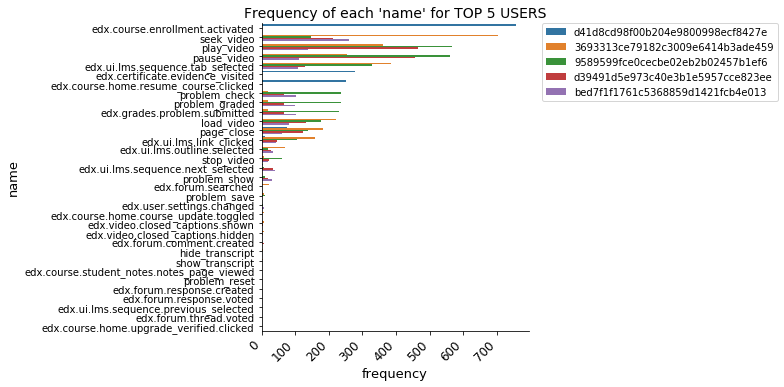

In [26]:
#make a horizontal bar plot with side by side data
plt.figure(figsize=(10,5))

sns.catplot(x = 'values', y = 'name', hue = 'username', 
            data = top_users_count, kind="bar", legend = False, aspect = 1.5)
plt.title("Frequency of each 'name' for TOP 5 USERS", fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('frequency', fontsize=13)
plt.ylabel('name', fontsize=13)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

*should normalize data because each user has a different amount of clicks 

In [27]:
#TODO : rewrite normalize function so that its based on the user min/max, not total min/max
top_users_normalized_df = normalize_data_users(top_users_count)
top_users_normalized_df.columns = ['username', 'name', 'normalized']
top_users_normalized_df.head(6)

#remove very small occurences
for count in range(len(top_users_normalized_df)):
    if top_users_normalized_df['normalized'][count] < 0.05:
        top_users_normalized_df = top_users_normalized_df.drop(labels = [count], axis = 0)

top_users_normalized_df.head(2)

,username,name,normalized
0,d41d8cd98f00b204e9800998ecf8427e,edx.course.enrollment.activated,1.0
1,3693313ce79182c3009e6414b3ade459,seek_video,1.0


<Figure size 720x360 with 0 Axes>

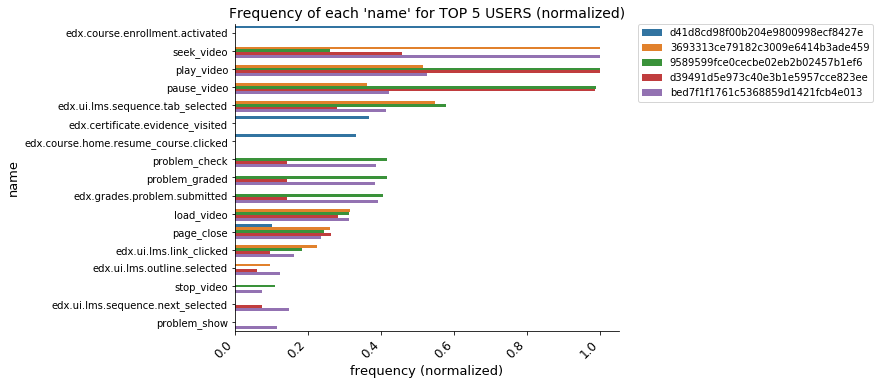

In [28]:
#make a horizontal bar plot with side by side data
plt.figure(figsize=(10,5))

sns.catplot(x = 'normalized', y = 'name', hue = 'username', 
            data = top_users_normalized_df, kind="bar", legend = False, aspect = 1.75)
plt.title("Frequency of each 'name' for TOP 5 USERS (normalized)", fontsize = 14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('frequency (normalized)', fontsize=13)
plt.ylabel('name', fontsize=13)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontsize='large'  
)

plt.show()

-removed weird outlier user from above graph
<br>-seek_video, play_video, pause_video are most popular
<br>-What is present on the mobile (ALL) graphs that is not present here? just edx.course.home.resume_course.clicked, edx.course.enrollment.activated (took out b/c outlier) (+page_close frequency is lower/seek_video is higher)
<br>-problem_graded, problem_check, edx.grades.problem.submitted are all the same?
<br>-same plot for top non-mobile users for comparison? what do we want to see? signifance tests--on what? not yet? next steps.
<br> time, proportions of totals